# Lecture 6: Neural Network Learning Part 4

3/16/2023

## Using Keras Library:
 - Binary Clasification
 - Multi Class Classification
 - Brain Tumor Dataset Classification

#### Import Libraries:

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from random import randint
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.datasets import 
from keras.callbacks import ModelCheckpoint
from keras.utils.np_utils import to_categorical # Convert Class Vectors to Binary Class Matrices
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score

#### Define Functions For Plotting:

In [3]:
# plot data points
def plot_fun(features, labels, classes, plotRange):
    plt.plot(features[labels[:] == classes[0], 0], features[labels[:] == classes[0], 1], 'rs',
             features[labels[:] == classes[1], 0], features[labels[:] == classes[1], 1], 'g^')
    plt.axis(plotRange)
    plt.title('Raw Data Plot For Both Classes')
    plt.xlabel('X_1: Feature 1')
    plt.ylabel('X_2: Feature 2')
    plt.legend(['Class ' + str(classes[0]), 'Class ' + str(classes[1])])
    plt.show()

# plot separating line: w1x1 + w2x2 + w0 = 0
def plot_fun_thr(features, labels, thresholdParams, learnRate, batchSize, classes):
    # plot data points
    plt.plot(features[labels[:] == classes[0], 0], features[labels[:] == classes[0], 1], 'rs',
             features[labels[:] == classes[1], 0], features[labels[:] == classes[1], 1], 'g^')
    plt.axis([-3, 3, -2, 4])
    # plot separating line
    x1 = np.linspace(-3, 3, 50)
    # w1x1 + w2x2 + w0 = 0 => x2 = -(w1x1 + w0) / w2
    x2 = -(thresholdParams[0] * x1 + thresholdParams[2]) / thresholdParams[1]
    plt.plot(x1, x2, '-b')
    plt.title(f'Data Classification:\nLearn Rate = {learnRate}, Batch Size = {batchSize}')
    plt.xlabel('X_1: Feature 1')
    plt.ylabel('X_2: Feature 2')
    plt.legend(['Class ' + str(classes[0]), 'Class ' + str(classes[1])])
    #plt.pause(0.5)
    #plt.show()

# plot training accuracy and loss
def plotCurve(trainingAccuracy, trainingLoss):
    epochs = np.arange(trainingLoss.shape[0])
    #print(epochs)
    plt.figure(figsize = [12, 6])
    plt.subplot(1, 2, 1)
    plt.plot(epochs, trainingAccuracy)
    #plt.axis([-1, 2, -1, 2])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, trainingLoss)
    plt.xlabel('Epoch')
    plt.ylabel('Binary CrossEntropy Loss')
    plt.title('Training Loss')
    plt.show()

# Plot MNIST Images in subplots
def img_plt(img, label):
    plt.figure(figsize=(12, 5.5))
    for i in range (1, 11):
        plt.subplot(2, 5, i)
        plt.imshow(img[i - 1, :, :], cmap = 'gray')
        plt.title('Label: ' + str(label[i - 1]))
    plt.show()

# Plot Features of MNIST data
def feat_plot(features, labels, classes):
    for class_i in classes:
        plt.plot(features[labels[:] == classes[class_i], 0], features[labels[:] == classes[class_i], 1], 'o', markersize = 5)
        # plt.axis([-2, 2, -2, 2])
        plt.xlabel('X: Feature 1')
        plt.ylabel('Y: Feature 2')
        plt.legend(['Class ' + str(classes[class_i]) for class_i in classes])
        plt.show()

#### Define Function For Feature Extraction From MNIST Images:

In [4]:
def feat_extract_bin(images):
    # Divide Each Image into 4 quadrants
    features = np.zeros((images.shape[0], 4))
    
    features_temp = np.sum(images[:, 0:int(images.shape[1] / 2), 0:int(images.shape[2] / 2)], axis = 2) # Quadrant 0
    features[:,0] = np.sum(features_temp, axis = 1) / (14*14) # Average Pixel Values
    
    features_temp = np.sum(images[:, 0:int(images.shape[1] / 2), int(images.shape[2] / 2):], axis = 2) # Quadrant 1
    features[:,1] = np.sum(features_temp, axis = 1) / (14*14) # Average Pixel Values
    
    features_temp = np.sum(images[:, int(images.shape[1] / 2):, 0:int(images.shape[2] / 2)], axis = 2) # Quadrant 2
    features[:,2] = np.sum(features_temp, axis = 1) / (14*14) # Average Pixel Values
    
    features_temp = np.sum(images[:, int(images.shape[1] / 2):, int(images.shape[2] / 2):], axis = 2) # Quadrant 3
    features[:,3] = np.sum(features_temp, axis = 1) / (14*14) # Average Pixel Values
    return features

def feat_extract_mult(images):
    width = images.shape[1]
    height = images.shape[2]
    features = np.zeros(images.shape[0], 4)

    features_temp = np.sum(images[:, 0:int(width / 2), 0:int(height / 2)], axis = 2) # Quadrant 0
    features[:,0] = np.sum(features_temp, axis = 1) / (width * height / 4) # Average Pixel Values
    
    features_temp = np.sum(images[:, 0:int(width / 2), int(height / 2):], axis = 2) # Quadrant 1
    features[:,1] = np.sum(features_temp, axis = 1) / (width * height / 4) # Average Pixel Values
    
    features_temp = np.sum(images[:, int(width / 2):, 0:int(height / 2)], axis = 2) # Quadrant 2
    features[:,2] = np.sum(features_temp, axis = 1) / (width * height / 4) # Average Pixel Values
    
    features_temp = np.sum(images[:, int(images.shape[1] / 2):, int(images.shape[2] / 2):], axis = 2) # Quadrant 3
    features[:,3] = np.sum(features_temp, axis = 1) / (width * height / 4) # Average Pixel Values
    return features

## Keras For Binary Classification:

#### Load MNIST Dataset & Split Into Training & Testing Sets:

In [5]:
# Load Data and Split to Training and Testing Sets:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

#print(x_train.shape) # (60000, 28, 28)
#print(y_train.shape) # (60000,)
#print(x_test.shape) # (10000, 28, 28)
#print(y_test.shape) # (10000,)

print('The number of Training Images =', x_train.shape[0])
print('The number of Training Labels =', y_train.shape[0])
print('The size of each Training Image is:', x_train.shape[1], 'by', x_train.shape[2], 'pixels \n')
print('The number of Testing Images =', x_test.shape[0])
print('The number of Testing Labels =', y_test.shape[0])
print('The size of each Testing Image is:', x_test.shape[1], 'by', x_test.shape[2], 'pixels')

The number of Training Images = 60000
The number of Training Labels = 60000
The size of each Training Image is: 28 by 28 pixels 

The number of Testing Images = 10000
The number of Testing Labels = 10000
The size of each Testing Image is: 28 by 28 pixels


#### Plot Digits 0 - 9 From The Training Set:

 - For Each Digit, Select A Random Sample.

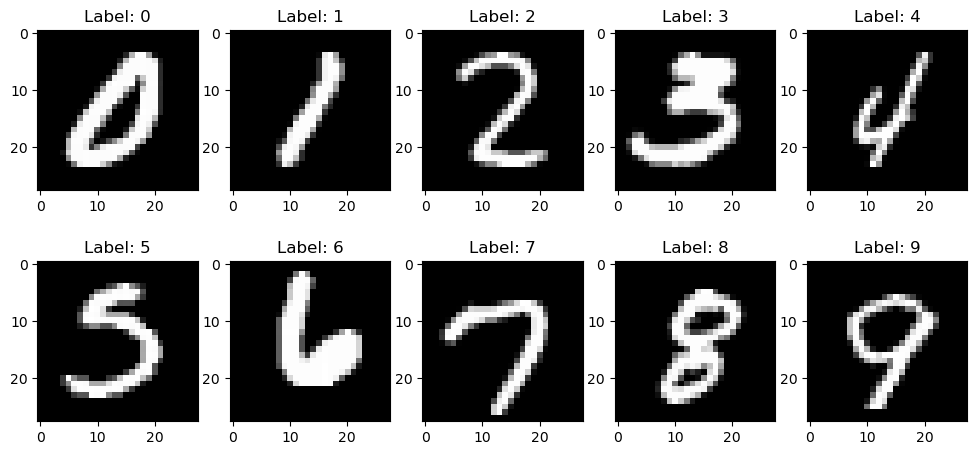

In [6]:
# Select 10 images from the training set
x_train_rnd = np.zeros((10, 28, 28))
y_train_rnd = np.arange(10)

for digit in range(10): # finds 10 images from the set
    x_train_d = x_train[y_train == digit,:,:]
    #x_train_rnd[digit,:,:] = x_train_d[0,:,:] # Select FIRST Digits From Set
    x_train_rnd[digit,:,:] = x_train_d[randint(0, x_train_d.shape[0]),:,:] # Select RANDOM Digits From Set

img_plt(x_train_rnd, y_train_rnd) # plot the images

#### Check Training and Test Sets:

In [7]:
# Check Training Data Set for correct amount of images:
x_train_TEST1 = x_train[y_train == 0] # Select all Zeros in Training Set
x_train_TEST2 = x_train[y_train == 1] # Select all Ones in Training Set
#print(x_train_TEST1.shape)
#print(x_train_TEST2.shape)
total1 = x_train_TEST1.shape[0] + x_train_TEST2.shape[0]
print(f'Total # of 0\'s and 1\'s in Training Set should be: {x_train_TEST1.shape[0]} + {x_train_TEST2.shape[0]} = {total1}\n')

# Check Test Data Set for correct amount of images:
x_test_TEST1 = x_test[y_test == 0] # Select all Zeros in Testing Set
x_test_TEST2 = x_test[y_test == 1] # Select all Ones in Testing Set
#print(x_test_TEST1.shape)
#print(x_test_TEST2.shape)
total2 = x_test_TEST1.shape[0] + x_test_TEST2.shape[0]
print(f'Total # of 0\'s and 1\'s in Test Set should be: {x_test_TEST1.shape[0]} + {x_test_TEST2.shape[0]} = {total2}\n')

Total # of 0's and 1's in Training Set should be: 5923 + 6742 = 12665

Total # of 0's and 1's in Test Set should be: 980 + 1135 = 2115



#### Select 0's and 1's From Training & Testing Sets:

In [8]:
## Actual Test and Training Set Declarations:
x_train_01 = x_train[np.logical_or(y_train == 1, y_train == 0),:,:] # Select ALL 1's and 0's from the Training Set.
y_train_01 = y_train[np.logical_or(y_train == 1, y_train == 0)] # Get labels for the digits.
#print(x_train_01.shape) # debug
#print(y_train_01.shape) # debug
print(f'Total Number of 0\'s and 1\'s in \'x_train_01\' is: {x_train_01.shape[0]}\n')

x_test_01 = x_test[np.logical_or(y_test == 1, y_test == 0),:,:] # Select ALL 8's and 0's from the Testing Set.
y_test_01 = y_test[np.logical_or(y_test == 1, y_test == 0)]
#print(x_test_01.shape) # debug
#print(y_test_01.shape) # debug
print(f'Total Number of 0\'s and 1\'s in \'x_test_01\' is: {x_test_01.shape[0]}\n')

Total Number of 0's and 1's in 'x_train_01' is: 12665

Total Number of 0's and 1's in 'x_test_01' is: 2115



#### Define The Model:

In [10]:
model1 = Sequential()
model1.add(Dense(input_dim = 4, units = 128, activation = 'tanh')) # Hidden Layers
model1.add(Dense(units = 1, activation = 'sigmoid')) # Ouput Layer
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 128)               640       
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________


#### Compile, Fit and Evaluate Model:

In [ ]:
# Stochastic Gradient Descent
opt = tf.keras.optimizers.SGD(learning_rate = 0.0001) # try 0.001, 0.01

model1.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['accuracy'])

# Try batch_size = 16 & epochs = 5
history1 = model1.fit(feature_train, y_train_01, batch_size=32, epochs=10, verbose=1)

#### Plot The Accuracy and Training Loss:

In [ ]:
plt.figure(figsize=[9, 5])
accuracyCurve = np.array(history1.history['accuracy'])
lossCurve = np.array(history1.history['loss'])
plotCurve(accuracyCurve, lossCurve)

#### Calculate Evaluation Metrics:

In [ ]:
# Predict Class of Held-Out Samples:

testClass1Prob = model1.predict(feature_test)
testLabels1 = np.uint8(testClass1Prob > 0.5)

testAccuracy1 = accuracy_score(testLabels1, y_test_01)
print('Accuracy Using Testing Set: ', testAccuracy1)

confusionMatrix1 = confusion_matrix(testLabels1, y_test_01)
print('The Confusion Matrix Using Testing Set: \n', confusionMatrix1)

sensitivity = (confusionMatrix1[1,1] / (confusionMatrix1[1,0] + confusionMatrix1[1,1])) * 100
print('The Sensitivity Using The Testing Set = %0.2f %' %sensitivity)

specificity = (confusionMatrix1[0,0] / (confusionMatrix1[0,0] + confusionMatrix1[0,1])) * 100
print('The Specificity Using Testing Set = %0.2f %' %specificity)

## Keras For Multiclass Classification:

### Select MNIST Digits 0, 1 and 2:

 - Define Digit Classes
 - Create an array of the images
 - Create a 2nd array of labels for the images

In [ ]:
classes1 = [0, 1, 2]
x_train_012 = x_train[np.logical_or.reduce((y_train == 0, y_train == 1, y_train == 2)), 0:28, 0:28]
y_train_012 = x_train[np.logical_or.reduce((y_train == 0, y_train == 1, y_train == 2))]

#### Plot Features of 500 Training Images:

In [ ]:
feat_plot(feature_train[1:500, 0:2], y_train_012[1:500], classes1)
feat_plot(feature_train[1:500, 2:4], y_train_012[1:500], classes1)

#### Define Model For Multiclass Classification:

In [ ]:
model2 = Sequential()
model2.add(Dense(input_dim = 4, units = 256, activation = 'tanh')) # Hidden Layer 1
model2.add(Dense(untis = 16, activation = 'tanh')) # Hidden Layer 2
model2.add(Dense(units = len(classes1), activation = 'softmax')) # Output Layer
model2.summary()

#### Compile, Fit and Evaluate The Model:

In [ ]:
y_train_012_c = to_categorical(y_train_012, len(classes1))
y_val_012_c = to_categorical(y_val_012, len(classes1))
y_test_012_c = to_categorical(y_test_012, len(classes1))

opt2 = tf.keras.optimizers.SGD(learning_rate = 0.001) # Stochastic Gradient Descent
model2.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

history2 = model2.fit(feature_train, y_train_012_c, batch_size=16, epochs=50, verbose=1)

scoreTrain = model2.evaluate(feature_train, y_test_012_c)
print('Total Loss From Training Set: ', scoreTrain[0])
print('Accuracy of Training Set: ', scoreTrain[1])

scoreValid2 = model2.evaluate(feature_val, y_val_012_c)
print('Total Loss From Training Set: ', scoreValid2[0])
print('Accuracy of Training Set: ', scoreValid2[1])

#### Plot Training Accuracy and Loss:

In [ ]:
plt.figure(figsize=[9, 5])
accuracyCurve2 = np.array(history2.history['accuracy'])
lossCurve2 = np.array(history2.history['loss'])
plotCurve(accuracyCurve2, lossCurve2)

#### Predict Class Of Held Out Samples & Calculate Evaluation Metrics:

In [ ]:
testClass2Prob = model2.predict(feature_test)
testLabels2 = np.argmax(testClass2Prob, axis = 1)

testAccuracy2 = accuracy_score(testLabels2, y_test_012)
print('The Accuracy Using The Test Set = ', testAccuracy2)

confusionMatrix2 = confusion_matrix(testLabels2, y_test_012)
print('The Confustion Matrix Using Testing Set Is: \n', confusionMatrix2)

### Select MNIST Digits 0 - 9:

 - Each individual MNIST image is 28 x 28 pixels

#### Create 10 Classes for Digits 0 - 9:

In [11]:
classes2 = np.arange(10)
print(classes2)

[0 1 2 3 4 5 6 7 8 9]


#### Flatten The Images:

In [ ]:
x_train_flat = np.reshape(x_train, (x_train.shape[0], x_train.shape[1] * x_train.shape[2]))
x_val_flat = np.reshape(x_val, (x_val.shape[0], x_val.shape[1] * x_val.shape[2]))
x_test_flat = np.reshape(x_test, (x_test.shape[0], x_test.shape[1] * x_test.shape[2]))

#### Scaling Each Pixel Value In The Range [0, 1]

 - Calculate min and max of each feature based on the training set.
 - Scale each feature in all sets:

 ##### $$ X_{scaled} = \frac{X - X_{min}}{X_{max} - {X_{min}}} $$

In [ ]:
x_train_flat = x_train_flat.astype('float32')
x_train_flat /= 255

x_val_flat = x_val_flat.astype('float32')
x_val_flat /= 255

x_test_flat = x_test_flat.astype('float32')
x_test_flat /= 255

#### Define Model For 10 Classes:

In [ ]:
model3 = Sequential()
model3.add(Dense(input_dim = x_train_flat.shape[1], units=512, activation='tanh')) # Hidden Layer 1
model3.add(Dense(units=512, activation='tanh')) # Hidden Layer 2
model3.add(Dense(units=len(classes2), activation='softmax')) # Output Layer (10 classes = 10 neurons)
model3.summary()

#### Compile, Fit & Evaluate Model:

In [ ]:
opt3 = tf.keras.optimizers.SGD(learning_rate=0.001)
model3.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# Convert Class Vectors To Binary Class Matrices:
y_train_c = to_categorical(y_train, len(classes2))
y_val_c = to_categorical(y_val, len(classes2))
y_test_c = to_categorical(y_test, len(classes2))

history3 = model3.fit(x_train_flat, y_train_c, batch_size=16, epochs=50, verbose=1)

scoreValid3 = model3.evaluate(x_val_flat, y_val_c)
print('Total Loss On Validation Set: ', scoreValid3[0])
print('Accuracy Of Validation Set: ', scoreValid3[1])

plt.figure(figsize=[9, 5])
accuracyCurve3 = np.array(history3.history['accuracy'])
lossCurve3 = np.array(history3.history['loss'])
plotCurve(accuracyCurve3, lossCurve3)

#### Predict Classes Of Held Out Samples:

In [ ]:
testClass3Prob = model3.predict(x_test_flat)
testLabels3 = np.argmax(testClass3Prob, axis = 1)

testAccuracy3 = accuracy_score(testLabels3, y_test)
print('The Accuracy Using The Testing Set Is: ', testAccuracy3)

confusionMatrix3 = confusion_matrix(testLabels3, y_test)
print('The Confusion Matrix Using Testing Set Is: \n', confusionMatrix3)

#### Saving The Best Model:

 - Create a checkpoint to save the best model based on the lowest validation loss.
 - Send the validation set to the `fit()` function.
 - Load the best model during testing

In [ ]:
savePath = '../assets/Lecture6/model3_mnist.h5'
callbackSave = ModelCheckpoint(savePath, monitor='val_loss', verbose=0, save_best_only=True, period=1)

history3a = model3.fit(x_train_flat, y_train_c, batch_size=16, epochs=50, 
            verbose=1, validation_data=(x_val_flat, y_val_c), callbacks=[callbackSave])

model3a = load_model(savePath)
testClass3AProb = model3a.predict(x_test_flat)
testLabels3a = np.argmax(testClass3AProb, axis=1)

testAccuracy3a = accuracy_score(testLabels3a, y_test)
print('The Accuracy Using The Testing Set = ', testAccuracy3a)